In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import math
from util import *
from vectoradam import *
from skimage import measure
from skimage.draw import disk
import imageio
import scipy
from nanomesh import Image as nmImg
from nanomesh import Mesher2D
import trimesh
import cv2
from svgpathtools import svg2paths
import mediapipe as mp
from einops import rearrange
from scipy.ndimage import gaussian_filter1d
from shapely.geometry import Polygon, Point

## TODO
- Fully connect each horizontal and vertical trace
- Extrude inward to get soldermask
- Extrude outward to get outer edge cut
- Cut of maybe 2 cm below the mediapipe wrist.
- Place connector placeholder for start of the traces, route traces to the connector
- Erode and dilate for inner cuts
- Convert paths to two svg (one for top electrodes and one for bottom electrodes)

In [88]:
def samplePaths(file, NUM_SAMPLES=100000):
    # Load paths from SVG file
    paths, attributes = svg2paths(file)
    points = []
    line_segments = []
    for path in paths:
        for i in range(NUM_SAMPLES):
            points.append([path.point(i/(NUM_SAMPLES-1)).imag, path.point(i/(NUM_SAMPLES-1)).real])
            if i < NUM_SAMPLES: line_segments.append((i, i+1))

    return np.array(points), line_segments
        
# outerCut, _ = samplePaths('assets/outerOnly.svg')
# topTraces, _ = samplePaths('assets/top_trace.svg')
# botttomTraces, _ = samplePaths('assets/bottom_trace.svg')
# edgeCuts, _ = samplePaths('assets/edgeCuts.svg')
# coverlayMask, _ = samplePaths('assets/solderMask.svg')



# # Print the flipped vertices
# plt.scatter(*zip(*outerCut), color='blue',s=1)
# # plt.scatter(*zip(*topTraces), color='red',s=1)
# # plt.scatter(*zip(*botttomTraces), color='green',s=1)
# # plt.scatter(*zip(*edgeCuts), color='purple',s=1)
# plt.scatter(*zip(*coverlayMask), color='orange',s=1)

C:\Users\devin\AppData\Local\Temp\ipykernel_41580\976929710.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread('assets/right-hand-real.jpg')


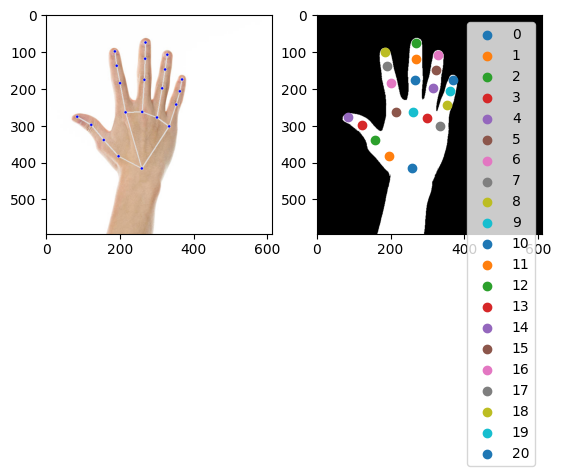

In [2]:
# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
mp_draw = mp.solutions.drawing_utils

image = imageio.imread('assets/right-hand-real.jpg')

# Process the frame
result = hands.process(image)

binary_image = image.sum(-1) / (255*3)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
mask = binary_image < (binary_image.max()*0.9)

mask_rgb = rearrange(np.array(np.vstack([mask, mask, mask])*255, dtype=np.uint8), '(c h) w -> h w c', c=3) 
cv2.imwrite('mask.png', mask_rgb)
mask = cv2.imread("mask.png")  # Replace with your image
h, w = mask.shape[0], mask.shape[1]

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax2.imshow(mask)

# Draw landmarks and extract fingertip positions
if result.multi_hand_landmarks:
    for hand_landmarks in result.multi_hand_landmarks:
        mp_draw.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
        hand_vertices = []
    for hand_landmarks in [result.multi_hand_landmarks[0]]:
        for idx in range(len(hand_landmarks.landmark)):
            x = (hand_landmarks.landmark[idx].x)
            y = (hand_landmarks.landmark[idx].y)
            ax2.scatter(x*w, y*h, label=f'{idx}')
            hand_vertices.append((x, y))
        mp_draw.draw_landmarks(mask, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    hand_vertices = np.array(hand_vertices)
ax1.imshow(image)
plt.legend()
plt.show()

hand_landmarks = result.multi_hand_landmarks[0]


In [24]:

def get_finger_rectangle_patch(landmarks, mask, finger_indices):
    """
    Given the landmarks of a hand and a binary mask, this function finds rectangular patches
    for the given finger joints.
    
    :param landmarks: List of hand landmarks from MediaPipe (21 landmarks).
    :param mask: Binary mask of the hand (numpy array).
    :param finger_indices: List of tuples of indices for the finger joints, e.g., for the index finger, 
                            [(2, 3), (3, 4)] where 2 is the base joint and 4 is the fingertip.
    :return: List of rectangles (x, y, w, h) for each finger joint pair.
    """
    finger_rectangles = []
    
    # Loop through each set of finger joint pairs
    for start_idx, end_idx in finger_indices:
        # Get the 2D coordinates of the joints
        start_joint = landmarks[start_idx]
        end_joint = landmarks[end_idx]
        
        # Extract the x, y positions
        start_x, start_y = int(start_joint.x * mask.shape[1]), int(start_joint.y * mask.shape[0])
        end_x, end_y = int(end_joint.x * mask.shape[1]), int(end_joint.y * mask.shape[0])
        
        # Calculate the height and width of the rectangle
        width = int(np.linalg.norm([start_x - end_x, start_y - end_y]))  # Distance between joints
        height = int(np.linalg.norm([start_x - end_x, start_y - end_y]))  # Same as width in this case
        
        # Find the bounding box (x, y, w, h) between the two points
        x1 = min(start_x, end_x)
        y1 = min(start_y, end_y)
        x2 = max(start_x, end_x)
        y2 = max(start_y, end_y)
        
        # Define the rectangle as (x, y, width, height)
        finger_rectangles.append((x1, y1, x2 - x1, y2 - y1))

    return finger_rectangles

ratios={
    2:0.87,
    3:0.89,
    4:0.94,
    5:0.87
    }

def point_along_line(A, B, t, landmarks):
    """
    Finds a point t% along the line segment from A to B using vector projection.

    Args:
    A, B (tuple): Start and end points of the line segment (x, y).
    t (float): Fraction of the way along the segment (0 to 1).

    Returns:
    array: Coordinates of the interpolated point.
    """
    return np.array(landmarks[A]) + t * (np.array(landmarks[B]) -np.array(landmarks[A]))

def point_along_line_distance(A, B, t, landmarks):
    """
    Finds a point t units along the line segment from A to B.

    Args:
    A, B (tuple): Start and end points of the line segment (x, y).
    t (float): Distance along the segment from point A.
    landmarks (dict): Dictionary of points with coordinates as (x, y).

    Returns:
    array: Coordinates of the interpolated point.
    """
    A_coords = np.array(landmarks[A])
    B_coords = np.array(landmarks[B])
    
    # Compute the vector from A to B
    AB_vector = B_coords - A_coords
    
    # Compute the total length of the segment
    segment_length = np.linalg.norm(AB_vector)
    
    # Find the interpolation factor (t_ratio) as t / segment_length
    t_ratio = t / segment_length if segment_length != 0 else 0
    
    # Calculate the point at the given length along the segment
    return A_coords + t_ratio * AB_vector


def compute_perpendicular_vector(vector):
    """
    Compute a perpendicular vector in 2D.
    :param vector: Input vector (x, y).
    :return: Perpendicular vector (rotated 90 degrees counterclockwise).
    """
    return np.array([-vector[1], vector[0]])

def calculate_rectangle(joint1, joint2, width):
    """
    Given two joints as the length of the rectangle and a width,
    calculate the rectangle's four corners.

    :return: 4 points of the rectangle, in clockwise order starting from the top left point
    """
    # Vector from joint1 to joint2
    length_vector = np.array(joint2) - np.array(joint1)
    length = np.linalg.norm(length_vector)
    if length == 0:
        return None  # Avoid division by zero
    
    # Unit vector along the length
    unit_length_vector = length_vector / length
    
    # Perpendicular vector (rotated 90 degrees)
    perp_vector = np.array([-unit_length_vector[1], unit_length_vector[0]]) * width / 2
    
    # Calculate the corners of the rectangle
    p1 = joint1 + perp_vector
    p2 = joint1 - perp_vector
    p3 = joint2 - perp_vector
    p4 = joint2 + perp_vector
    
    return np.array([p1, p2, p3, p4], dtype=np.int32)

def get_finger_polygons(mp_landmarks, mask,  width=10):
    """
    Compute polygons along the finger direction for each segment of the finger.
    
    :param landmarks: List of hand landmarks from MediaPipe (21 landmarks).
    :param mask: Binary mask of the hand (numpy array).
    :param finger_indices: List of tuples of indices for the finger joints.
    :param width: Half-width of the finger polygons.
    :return: List of polygons (each defined by four points).
    """
    finger_polygons = []
    
    landmarks = [(int(lm.x * image.shape[1]), int(lm.y * image.shape[0])) for lm in mp_landmarks]
    joint_pairs = {
        't1': (point_along_line(4,3,0.1,landmarks), point_along_line(4,3,0.9,landmarks)),
        't2': (point_along_line(3,2,0.1,landmarks), point_along_line(3,2,0.9,landmarks)),
    }

    # Example: Iterate over fingers
    for finger_idx in range(2,6):  # 5 fingers
        # MCP, PIP, DIP, TIP indices for each finger
        mcp_idx = 5 + (finger_idx-2) * 4
        pip_idx = mcp_idx + 1
        dip_idx = pip_idx + 1
        tip_idx = dip_idx + 1
        joint_pairs['d'+str(finger_idx)+'p1'] = (point_along_line(tip_idx, dip_idx, 0.05, landmarks),point_along_line(tip_idx, dip_idx, 0.9, landmarks))
        joint_pairs['d'+str(finger_idx)+'p2'] = (point_along_line(dip_idx, pip_idx, 0.1, landmarks),point_along_line(dip_idx, pip_idx, 0.9, landmarks))
        p2Length = np.linalg.norm(np.array(landmarks[pip_idx])-np.array(landmarks[dip_idx]))
        joint_pairs['d'+str(finger_idx)+'p3'] = (point_along_line(pip_idx, mcp_idx, 0.1, landmarks),point_along_line_distance(pip_idx, mcp_idx, p2Length*ratios[finger_idx], landmarks))

        # Example: Width as average distance between MCP and PIP
    regionDict={}
    for region in list(joint_pairs.keys()):
        joints = joint_pairs[region]
        joint1 = joints[0]
        joint2 = joints[1]
        width = np.linalg.norm(np.array(joint1) - np.array(joint2)) * 0.5

        # Calculate the rectangle
        rectangle = calculate_rectangle(joint1, joint2, width)

        regionDict[region] = (joints, rectangle)
    
    return regionDict




def sample_and_connect_polygon_sides(polygon, num_points=3):
    """
    Sample equal spaced points on the two vertical sides of a polygon and connect them with lines.
    
    :param polygon: A polygon defined by four points (point1, point2, point3, point4).
    :param num_points: Number of equal spaced points to sample on each side.
    :return: A list of lines connecting the sampled points.
    """
    # Extract the points defining the polygon
    point1, point2, point3, point4 = polygon
    
    # Interpolate points on side1 (point1 -> point4) and side2 (point2 -> point3)
    side1_points = np.linspace(point1, point4, num_points)
    side1_points = side1_points[1:-1]
    side2_points = np.linspace(point2, point3, num_points)
    side2_points = side2_points[1:-1]
    
    # Connect corresponding points
    connecting_lines = [[side1_points[i], side2_points[i]] for i in range(num_points-2)]
    
    return connecting_lines



def sample_and_connect_polygon_other_sides(polygon, num_points=5):
    """
    Sample equal spaced points on the two vertical sides of a polygon and connect them with lines.
    
    :param polygon: A polygon defined by four points (point1, point2, point3, point4).
    :param num_points: Number of equal spaced points to sample on each side.
    :return: A list of lines connecting the sampled points.
    """
    # Extract the points defining the polygon
    point1, point2, point3, point4 = polygon
    
    # Interpolate points on side1 (point1 -> point4) and side2 (point2 -> point3)
    side1_points = np.linspace(point1, point2, num_points)
    side1_points = side1_points[1:-1]
    side2_points = np.linspace(point4, point3, num_points)
    side2_points = side2_points[1:-1]
    
    # Connect corresponding points
    connecting_lines = [[side1_points[i], side2_points[i]] for i in range(num_points-2)]
    
    return connecting_lines

def draw_electrodes(ax, horizontal_electrodes, vertical_electrodes):
    """
    Draw the horizontal electrode traces (blue) and vertical electrode traces (cyan)
    
    :param ax: Figure axes
    :param horizontal_electrodes: Array of electrodes as (point1, point2)
    :param vertical_electodes: Array of electrodes as (point1, point2)
    """
    for point1, point2 in horizontal_electrodes:
        ax.plot([point1[0], point2[0]], [point1[1], point2[1]], color='blue', linewidth=1)

    for point1, point2 in vertical_electrodes:
        ax.plot([point1[0], point2[0]], [point1[1], point2[1]], color='cyan', linewidth=1)
    
    
def draw_finger_polygons_with_matplotlib(ax, image, finger_polygons, horizontal_traces, vertical_traces):
    """
    Draws the polygons on the given image using Matplotlib.
    
    :param image: Input image (numpy array).
    :param finger_polygons: List of polygons (each defined by four points).
    """
    ax.imshow(image, cmap='gray')
    
    # Draw each polygon
    for polygon_points in finger_polygons:
        polygon = Polygon(polygon_points, closed=True, edgecolor='r', fill=False, linewidth=2)
        ax.add_patch(polygon)
    draw_electrodes(ax, horizontal_traces, vertical_traces)

def project(A, B, C):
    """
    Projects point C onto the infinite line through points A and B.

    Args:
    A, B, C (tuple): Coordinates of points A, B, and C as (x, y).

    Returns:
    array: Coordinates of the projected point.
    """
    A_coords = np.array(A)
    B_coords = np.array(B)
    C_coords = np.array(C)
    
    # Vector from A to B
    AB = B_coords - A_coords
    
    # Vector from A to C
    AC = C_coords - A_coords
    
    # Project AC onto AB
    AB_norm_sq = np.dot(AB, AB)  # Squared norm of AB
    if AB_norm_sq == 0:
        # A and B are the same point, projection is undefined; return A
        return A_coords
    
    projection_factor = np.dot(AC, AB) / AB_norm_sq  # Scalar projection
    projection = A_coords + projection_factor * AB  # Projected point
    
    return projection

import numpy as np

def line_orthogonal_to_AB(A, B, t=1):
    """
    Finds a point C on the line AC orthogonal to AB.
    
    Parameters:
        A (np.ndarray): Coordinates of point A as a numpy array [x1, y1].
        B (np.ndarray): Coordinates of point B as a numpy array [x2, y2].
        t (float): A parameter to control the distance of C from A.
    
    Returns:
        np.ndarray: Coordinates of point C as a numpy array [x, y].
    """
    # Direction vector of AB
    d = B - A
    
    # Orthogonal vector to AB (swap and negate one component)
    orthogonal_vector = np.array([-d[1], d[0]])
    
    # Point C is obtained by moving along the orthogonal vector
    C = A + t * orthogonal_vector
    return C

def line_intersection(p1, p2, p3, p4):
    """
    Finds the intersection of two lines: (p1, p2) and (p3, p4).
    
    Parameters:
        p1, p2: Points on the first line (numpy arrays).
        p3, p4: Points on the second line (numpy arrays).
    
    Returns:
        np.ndarray or None: Intersection point [x, y] as a numpy array, or None if lines are parallel.
    """
    # Line vectors
    d1 = p2 - p1
    d2 = p4 - p3
    
    # Form the matrix for the linear system
    A = np.array([d1, -d2]).T
    b = p3 - p1
    
    # Check if lines are parallel
    if np.linalg.det(A) == 0:
        return None  # No intersection
    
    # Solve the linear system for the intersection point
    t = np.linalg.solve(A, b)
    intersection = p1 + t[0] * d1
    return intersection

# Example Usage
# A = np.array([1, 2])
# B = np.array([4, 6])
# D = np.array([0, 5])
# E = np.array([5, 0])

# # Find point C on the line AC orthogonal to AB
# C = line_orthogonal_to_AB(A, B)

# # Find the intersection of line AC with line DE
# intersection = line_intersection(A, C, D, E)

# print(f"Point C on line AC orthogonal to AB: {C}")
# print(f"Intersection of AC and DE: {intersection}")



def create_palm_region(handlandmarks, regionDict):
    landmarks = [(int(lm.x * image.shape[1]), int(lm.y * image.shape[0])) for lm in handlandmarks]
    # Sort the array by the first column (X values) in descending order
    pinkyPatch3 = regionDict['d5p3'][1]
    # sorted_array = pinkyPatch3[pinkyPatch3[:, 0].argsort()[::-1]]

    # # Take the first two rows
    # pinkyRight = sorted_array[:2]
    indexPatch3 = regionDict['d2p3'][1]
    C = line_orthogonal_to_AB(np.array(landmarks[0]),np.array(landmarks[9]))
    new0 = line_intersection(np.array(landmarks[0]), C, pinkyPatch3[1],pinkyPatch3[2])

    new1 = project(np.array(landmarks[0]), C, np.array(landmarks[1]))
    new1 = line_intersection(new1, new0, indexPatch3[0], indexPatch3[3])

    new3 = point_along_line(1,2, 0.5,landmarks)

    thumbPatch2 = regionDict['t2'][1]
    new3 = project(thumbPatch2[0], thumbPatch2[3], new3)

    
    # sorted_array2 = indexPatch3[indexPatch3[:, 0].argsort()]

    # # Take the first two rows
    # indexLeft = sorted_array2[:2]
    new2 = project(indexPatch3[0],indexPatch3[3],np.array(landmarks[5]))

    new4 = project(pinkyPatch3[1], pinkyPatch3[2], np.array(landmarks[17]))

    palmRegion = np.array([new0, new1,new3, new2,  np.array(landmarks[13]), new4])
    # palmRegion = palmRegion.reshape((-1, 1, 2)).astype(np.int32)
    return palmRegion

def interpolate_path(points, num_samples):
    """
    Interpolates `num_samples` evenly spaced points along a path defined by `points`.

    Args:
    - points (list of ndarray): Ordered points defining the path (e.g., [p1, p2, p3, ...]).
    - num_samples (int): Total number of points to sample along the path.

    Returns:
    - sampled_points (list of ndarray): Interpolated points along the path.
    """
    # Compute lengths of all segments
    segment_lengths = [np.linalg.norm(points[i + 1] - points[i]) for i in range(len(points) - 1)]
    total_length = sum(segment_lengths)

    # Compute the cumulative lengths for mapping
    cumulative_lengths = np.cumsum([0] + segment_lengths)

    # Generate evenly spaced distances along the total path
    distances = np.linspace(0, total_length, num_samples)

    # Interpolate points along the path
    sampled_points = []
    for dist in distances:
        # Find the corresponding segment
        for i in range(len(points) - 1):
            if cumulative_lengths[i] <= dist <= cumulative_lengths[i + 1]:
                # Interpolate within the segment
                t = (dist - cumulative_lengths[i]) / segment_lengths[i]
                interpolated_point = (1 - t) * points[i] + t * points[i + 1]
                sampled_points.append(interpolated_point)
                break

    return sampled_points

# # Example usage
# palm_path_1 = [np.array([0, 0]), np.array([0.5, 1]), np.array([1, 0])]  # Path p1 -> p2 -> p3
# palm_path_2 = [np.array([1, 0]), np.array([0.5, -1]), np.array([0, 0])]  # Path p4 -> p5 -> p6

# num_samples = 13

# sampled_points_path1 = interpolate_path(palm_path_1, num_samples)
# sampled_points_path2 = interpolate_path(palm_path_2, num_samples)

# # Combine into line segments (pairs of points for connections)
# line_segments = [(sampled_points_path1[i], sampled_points_path2[i]) for i in range(num_samples)]

# # Display results
# for segment in line_segments:
#     print(f"Start: {segment[0]}, End: {segment[1]}")


def sample_traces_palm(palmPolygon, numVertical=13, numHorizontal=9):
    #Extract points
    p1, p2, p3, p4, p5, p6 = palmPolygon
     # Interpolate points on side1 (point1 -> point4) and side2 (point2 -> point3)
    side1_points = np.linspace(p1, p6, numHorizontal)
    side1_points = side1_points[1:-1]
    middle_points = np.linspace(p2, p5, numHorizontal)
    middle_points = middle_points[1:-1]
    side2_points = np.linspace(p3, p4, numHorizontal)
    side2_points = side2_points[1:-1]
    
    # Connect corresponding points
    horizontalTraces = [[side1_points[i], middle_points[i], side2_points[i]] for i in range(numHorizontal-2)]

    bottompoints = interpolate_path(np.array([p1,p2,p3]),numVertical)
    bottompoints = bottompoints[1:-1]
    toppoints = interpolate_path(np.array([p6,p5,p4]), numVertical)
    toppoints = toppoints[1:-1]
    vertical_traces = [[bottompoints[i], toppoints[i]] for i in range(numVertical-2)]
    return horizontalTraces, vertical_traces

def draw_palm_traces(ax, horizontal_traces, vertical_traces):
    for point1, point2, point3 in horizontal_traces:
        ax.plot([point1[0], point2[0], point3[0]], [point1[1], point2[1], point3[1]], color='cyan', linewidth=1)
    for point1, point2 in vertical_traces:
        ax.plot([point1[0], point2[0]], [point1[1], point2[1]], color='cyan', linewidth=1)
    



In [84]:
def construct_final_traces(fingerRegionDict, horizontalPalm, verticalPalm):
    final_horizontal = []
    final_vertical = []
    for i in range(4):
        trace = np.vstack([horizontalPalm[i], fingerRegionDict['t2'][3][i][::-1], fingerRegionDict['t1'][3][i][::-1]])
        final_horizontal.append(trace)
    for i in range(11):
        if i == 0:
            trace = np.vstack([verticalPalm[i],fingerRegionDict['d5p3'][3][1][::-1],fingerRegionDict['d5p2'][3][1][::-1],fingerRegionDict['d5p1'][3][1][::-1]])
        elif i == 1:
            trace = np.vstack([verticalPalm[i], fingerRegionDict['d5p3'][3][0][::-1], fingerRegionDict['d5p2'][3][0][::-1], fingerRegionDict['d5p1'][3][0][::-1]])
        elif i == 3:
            trace = np.vstack([verticalPalm[i], fingerRegionDict['d4p3'][3][1][::-1], fingerRegionDict['d4p2'][3][1][::-1], fingerRegionDict['d4p1'][3][1][::-1]])
        elif i == 4:
            trace = np.vstack([verticalPalm[i], fingerRegionDict['d4p3'][3][0][::-1], fingerRegionDict['d4p2'][3][0][::-1] , fingerRegionDict['d4p1'][3][0][::-1]])
        elif i == 6:
            trace = np.vstack([verticalPalm[i], fingerRegionDict['d3p3'][3][1][::-1], fingerRegionDict['d3p2'][3][1][::-1], fingerRegionDict['d3p1'][3][1][::-1]])
        elif i == 7:
            trace = np.vstack([verticalPalm[i], fingerRegionDict['d3p3'][3][0][::-1], fingerRegionDict['d3p2'][3][0][::-1], fingerRegionDict['d3p1'][3][0][::-1]])
        elif i == 9:
            trace = np.vstack([verticalPalm[i], fingerRegionDict['d2p3'][3][1][::-1], fingerRegionDict['d2p2'][3][1][::-1], fingerRegionDict['d2p1'][3][1][::-1]])
        elif i == 10:
            trace = np.vstack([verticalPalm[i], fingerRegionDict['d2p3'][3][0][::-1], fingerRegionDict['d2p2'][3][0][::-1], fingerRegionDict['d2p1'][3][0][::-1]])
        else:
            trace = np.array(verticalPalm[i])
        final_vertical.append(trace)
    return (final_horizontal, final_vertical)

def plotFinalTraces(ax, final_horizontal, final_vertical):
    for trace in final_horizontal:
        ax.plot([trace[i][0] for i in range(len(trace))], [trace[i][1] for i in range(len(trace))], color='green', linewidth=1)
    for trace in final_vertical:
        ax.plot([trace[i][0] for i in range(len(trace))], [trace[i][1] for i in range(len(trace))], color='magenta', linewidth=1)




[[[array([ 90.5, 288.5]), array([ 99.5, 273.5])], [array([ 98., 293.]), array([107., 278.])], [array([105.5, 297.5]), array([114.5, 282.5])]], [[array([126., 318.]), array([142., 305.])], [array([135., 329.]), array([151., 316.])]], [[array([178.25, 109.25]), array([195. , 106.5])], [array([179.5, 117.5]), array([196., 115.])], [array([180.75, 125.75]), array([197. , 123.5])]], [[array([183.75, 152.5 ]), array([202.75, 148.5 ])], [array([185.5, 162. ]), array([204.5, 158. ])], [array([187.25, 171.5 ]), array([206.25, 167.5 ])]], [[array([194.5 , 201.25]), array([210.75, 198.25])], [array([196. , 209.5]), array([212.5, 206.5])], [array([197.5 , 217.75]), array([214.25, 214.75])]], [[array([258.75,  84.5 ]), array([277.75,  85.25])], [array([258.5,  94. ]), array([277.5,  94.5])], [array([258.25, 103.5 ]), array([277.25, 103.75])]], [[array([255.5 , 134.25]), array([278.5 , 135.25])], [array([255. , 145.5]), array([278. , 146.5])], [array([254.5 , 156.75]), array([277.5 , 157.75])]], [[a

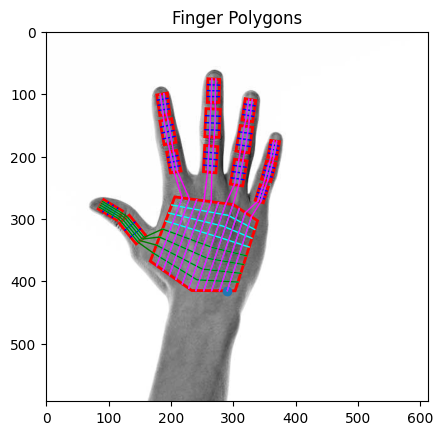

In [85]:
from matplotlib.patches import Rectangle, Polygon
fig, ax = plt.subplots()

# finger_joint_pairs = [[2, 3], [3, 4], [5, 6], [6, 7], [7, 8], [9, 10], [10, 11], [11, 12], [13, 14], [14, 15], [15, 16], [17, 18], [18, 19], [19, 20]]
regionDict = get_finger_polygons(hand_landmarks.landmark, mask)
electrode_traces = []
horizontal_traces = []
electrode_traces_other = []
vertical_traces = []
finger_rectangles = [regionDict[region][1] for region in list(regionDict.keys())]

#fingerRegionDict: maps region -> (defining joint pair, polygon, horizontal traces, vertical traces)
fingerRegionDict = {}

for region in list(regionDict.keys()):
    p = regionDict[region][1]
    if region == 't1':
        pHorizontal = sample_and_connect_polygon_sides(p, num_points=5)
        pVertical = sample_and_connect_polygon_other_sides(p, num_points=6)
    elif region == 't2':
        pHorizontal = sample_and_connect_polygon_sides(p, num_points=4)
        pVertical = sample_and_connect_polygon_other_sides(p, num_points=6)
    else:
        pHorizontal = sample_and_connect_polygon_sides(p, num_points=5)
        pVertical = sample_and_connect_polygon_other_sides(p, num_points=4)
    electrode_traces.append(pHorizontal)
    horizontal_traces += pHorizontal
    electrode_traces_other.append(pVertical)
    vertical_traces += pVertical
    fingerRegionDict[region] = (regionDict[region][0], regionDict[region][1], pHorizontal, pVertical)

print(electrode_traces)
draw_finger_polygons_with_matplotlib(ax, binary_image, finger_rectangles, horizontal_traces, vertical_traces) 

palmRegion = create_palm_region(hand_landmarks.landmark, regionDict)
horizontalPalm, verticalPalm = sample_traces_palm(palmRegion)
draw_palm_traces(ax, horizontalPalm, verticalPalm)
polygon = Polygon(palmRegion, closed=True, edgecolor='r', fill=False, linewidth=2)
horizontalFinal, verticalFinal = construct_final_traces(fingerRegionDict, horizontalPalm, verticalPalm)
print(type(verticalFinal[0]))
plotFinalTraces(ax, horizontalFinal, verticalFinal)
ax.add_patch(polygon)
ax.scatter(verticalFinal[0][0,0],verticalFinal[0][0,1])

    
plt.title("Finger Polygons")
# plt.axis('off')
plt.show()


In [ ]:
# point1 is bottom right hand corner, intersection of horizontal axis (line through landmark0 orthogonal to landmark0->landmark9)
# and line through right hand edge of pinky sensing patch 3
# point2 is hand landmark 1
# point3 is projection of landmark 5 along index sensing patch 3
# point4 is hand landmark 13
# point5 is projection of landmark 17 along pinky sensing patch 3

import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla

def biharmonic_weights(vertices, segments):
    """
    Compute biharmonic weights based on the mesh connectivity.
    """
    num_vertices = len(vertices)
    
    L = sp.lil_matrix((num_vertices, num_vertices))
    for seg in segments:
        i, j = seg
        L[i, i] += 1
        L[j, j] += 1
        L[i, j] -= 1
        L[j, i] -= 1

    A = L.T @ L
    return A

def deform_shape(source_vertices, target_vertices, segments, alpha=0.1):
    """
    Deform the source shape to match the target shape using biharmonic weights.
    
    Parameters:
    - source_vertices: Nx2 array of (x, y) coordinates of the source shape.
    - target_vertices: Nx2 array of (x, y) coordinates of the target shape.
    - segments: List of pairs of indices defining the edges between vertices.
    - alpha: Regularization parameter for the biharmonic weights.
    
    Returns:
    - deformed_vertices: Nx2 array of the deformed vertices.
    """
    num_vertices = source_vertices.shape[0]

    A = biharmonic_weights(source_vertices, segments)

    I = sp.identity(num_vertices)
    system_matrix = A + alpha * I  # Regularized biharmonic system

    bx = alpha * target_vertices[:, 0]
    by = alpha * target_vertices[:, 1]
    
    deformed_x = spla.spsolve(system_matrix, bx)
    deformed_y = spla.spsolve(system_matrix, by)
    
    deformed_vertices = np.vstack((deformed_x, deformed_y)).T
    return deformed_vertices



In [86]:
def extrude_contour(vertices, extrusion_distance):
    """
    Extrudes the contour outward by a given distance based on local normals.
    :param vertices: Nx2 array of contour vertices (x, y).
    :param extrusion_distance: Distance to extrude outward.
    :return: Extruded contour vertices (Nx2 array).
    """
    vertices = np.asarray(vertices)
    num_vertices = len(vertices)

    extruded_vertices = []
    for i in range(num_vertices):
        prev_vertex = vertices[i - 1]
        curr_vertex = vertices[i]
        next_vertex = vertices[(i + 1) % num_vertices]  # Wrap around

        tangent1 = curr_vertex - prev_vertex
        tangent2 = next_vertex - curr_vertex

        tangent1 /= np.linalg.norm(tangent1)
        tangent2 /= np.linalg.norm(tangent2)

        average_tangent = tangent1 + tangent2
        average_tangent /= np.linalg.norm(average_tangent)

        normal = np.array([-average_tangent[1], average_tangent[0]])

        extruded_vertex = curr_vertex + extrusion_distance * normal
        extruded_vertices.append(extruded_vertex)

    return np.array(extruded_vertices)


def intrude_contour(vertices, extrusion_distance):
    """
    Extrudes the contour outward by a given distance based on local normals.
    :param vertices: Nx2 array of contour vertices (x, y).
    :param extrusion_distance: Distance to extrude outward.
    :return: Extruded contour vertices (Nx2 array).
    """
    vertices = np.asarray(vertices)
    num_vertices = len(vertices)

    extruded_vertices = []
    for i in range(num_vertices):
        prev_vertex = vertices[i - 1]
        curr_vertex = vertices[i]
        next_vertex = vertices[(i + 1) % num_vertices]  # Wrap around

        tangent1 = curr_vertex - prev_vertex
        tangent2 = next_vertex - curr_vertex

        tangent1 /= np.linalg.norm(tangent1)
        tangent2 /= np.linalg.norm(tangent2)

        average_tangent = tangent1 + tangent2
        average_tangent /= np.linalg.norm(average_tangent)

        normal = np.array([-average_tangent[1], average_tangent[0]])

        extruded_vertex = curr_vertex - extrusion_distance * normal
        extruded_vertices.append(extruded_vertex)

    return np.array(extruded_vertices)


def extrude_concave_shape(vertices, extrusion_distance):
    """
    Extrudes a concave shape by a specified distance.
    :param vertices: Nx2 array of contour vertices (x, y).
    :param extrusion_distance: Distance to extrude outward.
    :return: Extruded contour vertices (Nx2 array).
    """
    # Convert the vertices into a Shapely Polygon
    polygon = Polygon(vertices)

    # Perform the buffer operation for extrusion
    extruded_polygon = polygon.buffer(extrusion_distance)

    # Get the exterior coordinates of the extruded shape
    extruded_vertices = np.array(extruded_polygon.exterior.coords)

    return extruded_vertices


def extrude_outward(mask, extrusion_distance):
    """
    Extrude a binary mask outward by a specified distance.
    :param mask: 2D numpy array (binary mask where 1s represent the hand).
    :param extrusion_distance: Distance to extrude outward (in pixels).
    :return: 2D numpy array of the outward-extruded mask.
    """
    kernel_size = int(extrusion_distance * 2 + 1)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    extruded_mask = cv2.dilate(mask, kernel)
    return extruded_mask

def extrude_inward(mask, extrusion_distance):
    """
    Extrude a binary mask inward by a specified distance.
    :param mask: 2D numpy array (binary mask where 1s represent the hand).
    :param extrusion_distance: Distance to extrude inward (in pixels).
    :return: 2D numpy array of the inward-extruded mask.
    """
    kernel_size = int(extrusion_distance * 2 + 1)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    extruded_mask = cv2.erode(mask, kernel)
    return extruded_mask



def smooth_hand_mask(binary_mask, blur_kernel_size=5, morph_kernel_size=3):
    """
    Smooths out the hand binary mask by applying Gaussian blur and morphological operations.
    :param binary_mask: 2D binary mask (1s for hand, 0s for background).
    :param blur_kernel_size: Size of the kernel for Gaussian blur.
    :param morph_kernel_size: Size of the kernel for morphological operations.
    :return: Smoothed binary mask.
    """
    # Apply Gaussian blur to smooth out local details
    smoothed_mask = cv2.GaussianBlur(binary_mask, (blur_kernel_size, blur_kernel_size), 0)
    
    # Threshold the image to convert it back to binary after blurring
    _, smoothed_mask = cv2.threshold(smoothed_mask, 127, 255, cv2.THRESH_BINARY)

    # Create a kernel for morphological operations (a square or elliptical kernel works well)
    kernel = np.ones((morph_kernel_size, morph_kernel_size), np.uint8)

    # Apply morphological opening (erosion followed by dilation) to remove small noise
    smoothed_mask = cv2.morphologyEx(smoothed_mask, cv2.MORPH_OPEN, kernel)

    # Optionally, apply closing (dilation followed by erosion) to fill small gaps
    smoothed_mask = cv2.morphologyEx(smoothed_mask, cv2.MORPH_CLOSE, kernel)

    return smoothed_mask


def contour_hand(binary_image, boundary=-1, num_points=100000):

    binary_image = binary_image[:boundary, :]
    binary_image = binary_image.sum(-1) / binary_image.sum(-1).max()

    # Find contours in the binary image
    contours = measure.find_contours(binary_image, level=0.5)
    
    points = []
    line_segments = []
    
    contours = [contours[0]]

    for contour in contours:
        distances = np.sqrt(np.sum(np.diff(contour, axis=0)**2, axis=1))
        cumulative_distances = np.insert(np.cumsum(distances), 0, 0)
        desired_distances = np.linspace(0, cumulative_distances[-1], num_points)
        interpolated_points = np.array([
            np.interp(desired_distances, cumulative_distances, contour[:, dim])
            for dim in range(contour.shape[1])
        ]).T
        
        points.extend(interpolated_points)
        
        for i in range(len(points) - 1):
            line_segments.append((i, i + 1))
        
        line_segments.append((i+1, 0))
    
    
    return np.array(points), line_segments



C:\Users\devin\AppData\Local\Temp\ipykernel_41580\692083734.py:65: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  binary_image = imageio.imread('mask.png')


original 58609710
255
[[337.   263.75]
 [350.   267.75]]
[array([326.5       , 256.99611322]), array([357.5       , 269.01350166])]


C:\Users\devin\AppData\Local\Temp\ipykernel_41580\692083734.py:96: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax3.scatter(newTracks[i][:, 0], newTracks[i][:, 1], s=0.05, c=colors[i], label=f'trace_{i+1}')


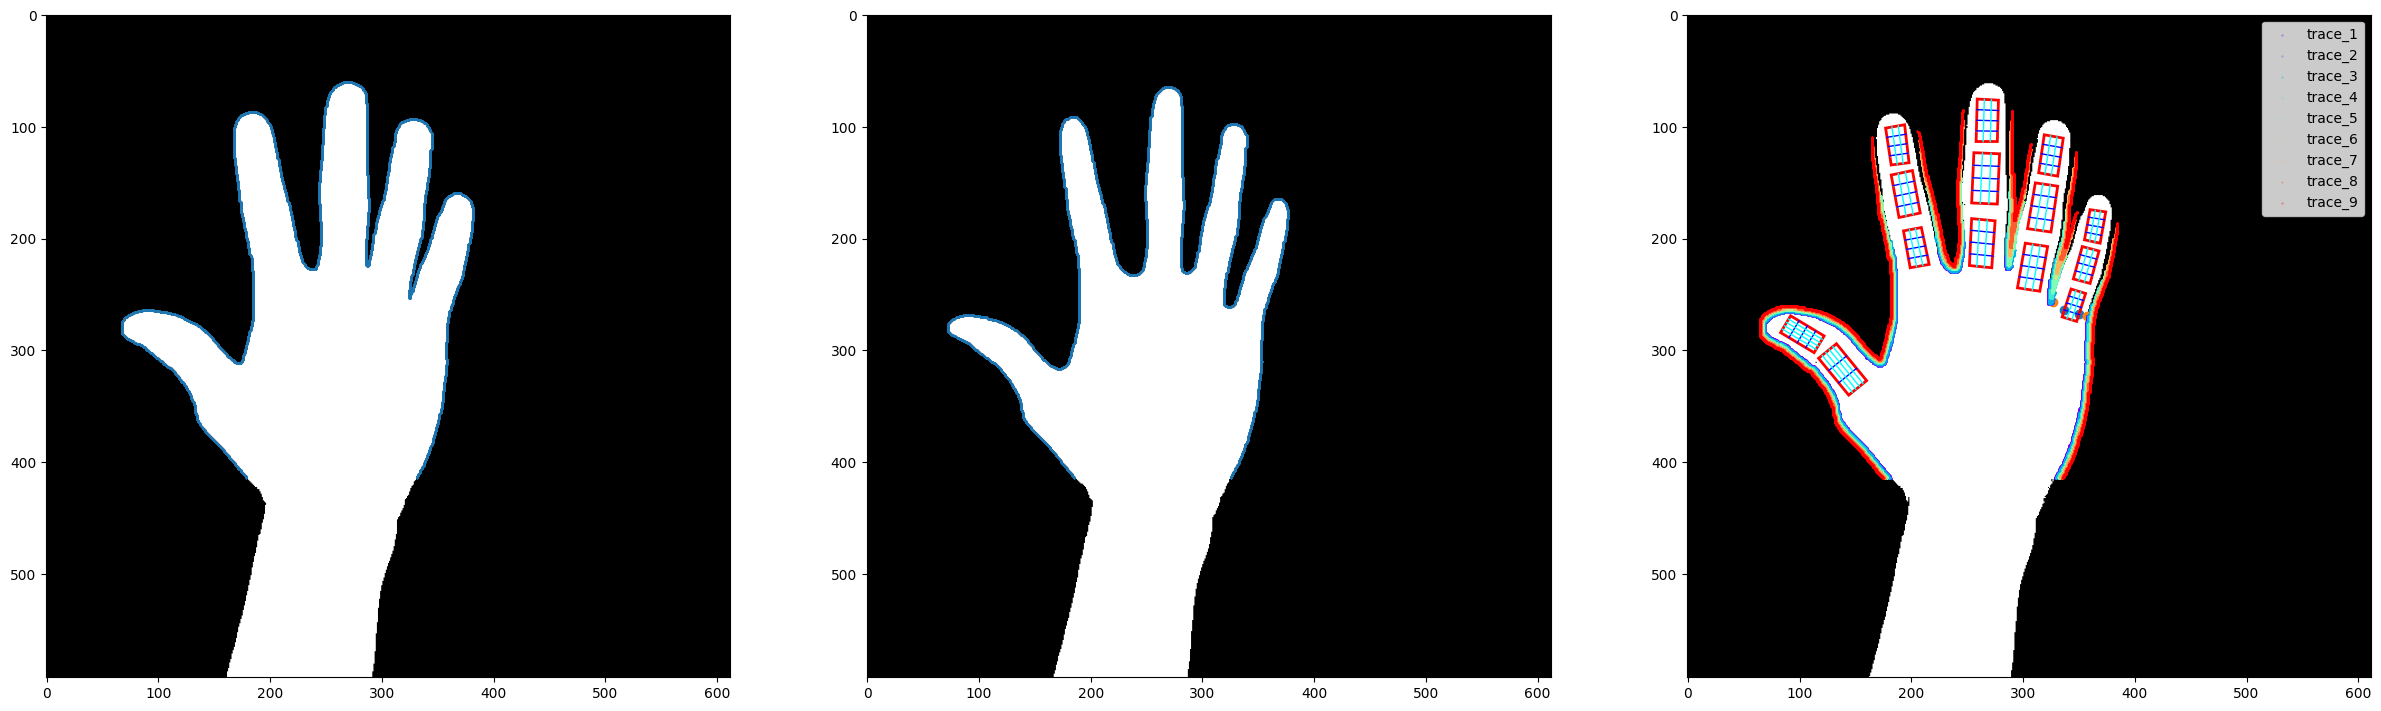

: 

In [ ]:
#extrude inward for the palm (7 traces)
#extrude outward for the fingers (9 traces)
#get closest point on track from both sides of the patch, replace

def euclidean_distance(p1, p2):
    return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5


def sample_track(ax3, fingerRegionDict, handEdge, boundary):
    newTracks = []
    for i in range(9):
        v2_inner = extrude_outward(handEdge, 0.7*(i))
        inner_target_l, _ = contour_hand(v2_inner, boundary)
        track=inner_target_l[:, [1, 0]]
        # if i == 0:
        #     ax3.scatter(track[:,0],track[:,1])
        for j in range(5,1,-1):
            patch = 'd'+str(j)+'p'+ str(3-i//3)
            electrode = i%3
            two_points = np.array(fingerRegionDict[patch][2][::-1][electrode])
            if i == 0 and j == 5:
                print(two_points)
                ax3.scatter(two_points[:,0], two_points[:,1])

            # find closest point on inner_target_l to each point, and create new track where each point in two_points
            # is connected to its closest point, and all points in between the two closest points are removed
            # (ie, closestPoint1, twoPoints1, twoPoints2, closestPoint2)
            # Find the closest points on `inner_target_l` to each point in `two_points`
            closest_points = []
            for point in two_points:
                closest_point = min(track, key=lambda p: euclidean_distance(point, p))
                closest_points.append(closest_point)
            if i == 0 and j == 5:
                print(closest_points)
                ax3.scatter(np.array(closest_points)[:,0], np.array(closest_points)[:,1])
            
            # Get indices of the closest points in `inner_target_l`
            closest_indices = [np.where((track == cp).all(axis=1))[0][0] for cp in closest_points]
            closest_indices.sort()  # Sort indices to maintain order
            
            idx_start, idx_end = closest_indices
            track = np.concatenate((track[:idx_start + 1], two_points, track[idx_end:]))
        newTracks.append(track)
    return newTracks
    
            
            
            





# source Link
inner_path, inner_segments = samplePaths('assets/solderMask.svg',5000)
outer_path, outer_segments = samplePaths('assets/outerOnly.svg',5000)
inner_path = inner_path / np.array(inner_path).max(0)
outer_path_n = outer_path / np.array(outer_path).max(0)

# Perform deformation
# bottom points for cutoff
hand_landmarks = result.multi_hand_landmarks[0]
x = (hand_landmarks.landmark[0].x)
y = (hand_landmarks.landmark[0].y)
binary_image = imageio.imread('mask.png')
boundary = int(y * mask.shape[0])


print('original', binary_image.sum())

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(30, 10))
print(binary_image.max())

smoothed_v2 = smooth_hand_mask(binary_image)

v2_outer = extrude_outward(smoothed_v2, 2)
outer_target, l_inner_target = contour_hand(v2_outer, boundary)
ax1.scatter(outer_target[:, 1], outer_target[:, 0], s=0.01)
ax1.imshow(v2_outer)

v2_inner = extrude_inward(smoothed_v2, 3)
inner_target, l_inner_target = contour_hand(v2_inner, boundary)
ax2.scatter(inner_target[:, 1], inner_target[:, 0], s=0.01)
ax2.imshow(v2_inner)


scalar_values = np.linspace(0, 1, 9)  # e.g., linearly spaced values from 0 to 1
# Create a colormap (e.g., 'viridis')
cmap = plt.cm.rainbow
colors = cmap(scalar_values)  # Map scalar values to colors
newTracks = sample_track(ax3, fingerRegionDict,smoothed_v2,boundary)
# draw_finger_polygons_with_matplotlib(ax3, binary_image, finger_rectangles)
draw_finger_polygons_with_matplotlib(ax3, binary_image,  finger_rectangles, horizontal_traces, vertical_traces)

for i in range(9):
    ax3.scatter(newTracks[i][:, 0], newTracks[i][:, 1], s=0.05, c=colors[i], label=f'trace_{i+1}')
    # v2_inner = extrude_inward(v2_outer, 0.7*(8-i))
    # inner_target_l, l_inner_target = contour_hand(v2_inner, boundary)
    # ax3.scatter(inner_target_l[:, 1], inner_target_l[:, 0], s=0.05, c=colors[i], label=f'trace_{i+1}')
    

ax3.legend()




/tmp/ipykernel_2930964/3836852406.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  binary_image = imageio.imread('mask.png')


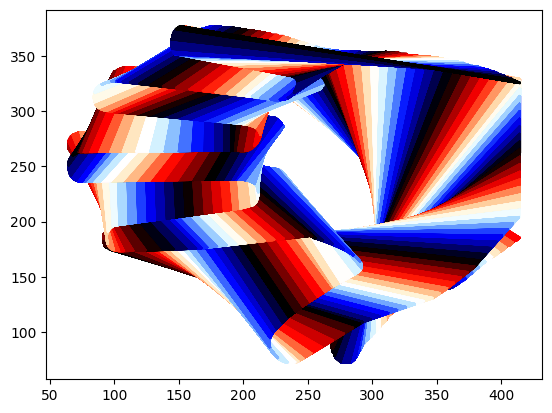

In [50]:
# map inner to inner, outer to outer

# rescale source to target:
s = (inner_target.max(0) - inner_target.min(0)) / (inner_path.max(0) - inner_path.min(0))
v_inner_target_n = s * ( inner_path - inner_path.min(0) ) + inner_target.min(0)

control_points_indices = np.linspace(0, v_inner_target_n.shape[0] - 1, num=10, dtype=int)

deformed_vertices = deform_shape(inner_path, inner_target, l_inner_target[:-1])

scalar_values = np.linspace(0, 1, v_inner_target_n.shape[0])  # e.g., linearly spaced values from 0 to 1
# Create a colormap (e.g., 'viridis')
cmap = plt.cm.flag
colors = cmap(scalar_values)  # Map scalar values to colors

# Define start and end points of the line segments
for i in range(v_inner_target_n.shape[0]):
    plt.plot((v_inner_target_n[i, 0], deformed_vertices[i, 0]), (v_inner_target_n[i, 1], deformed_vertices[i, 1]), color=colors[i])  # Plot as blue line
plt.show()


# plt.scatter(v_inner_target_n[:, 0], v_inner_target_n[:, 1], color='blue', s=5)
# plt.scatter(v2[:, 0], v2[:, 1], color='red', s=5)
# plt.show()
